### CS166 Assignment 3

## Network Model - Authoritarian Utopia

_Yoav Rabinovich, March 2019_

-------------------------------

As I one day intend to rule society with an iron fist, I've decided to leverage my knowledge of network dynamics to simulate a strategy for thought control. In this report, I modify a known adaptive model to fit my needs as supreme leader.

### The Basic Model

The basic opinion evolution adaptive network model on which this report will be expanding can be described as followed:

Each node in an undirected graph is associated with an opinion on an arbitrary topic, represented as a floating point number between 0 and 1. Each edge in the graph represents a relationship between two individuals, and is associated with a weight between 0.05 and 1 (weights lower than 0.05 are considered severed edges).

At each timestep, asynchronously, a random edge is chosen, and the linked nodes' opinion scores as well as the edge's weight are altered, simulating an interaction between the individuals. The stronger their relationship, the more the individuals influence each other's opinion, but the starker the difference of opinions, the more the exchange damages their relationship. This is modelled using three parameters:


- $\alpha \in (0,0.5]$, representing the ease at which opinions change
- $\beta \in (0,1)$, representing the ease at which relationship strength changes.
- $\gamma$, representing the effect of opinin difference on relationship strength change.

The changes in opinion and edge weight within each interaction between nodes $i$ and $j$ are then described by the following equations:

$$\Delta o_i = \alpha w_{ij}(o_j-o_i)$$
$$\Delta w_ij = \beta w_ij(1-w_ij)(1-\gamma|o_i-o_j|)$$

There is also a %1 probability for random relationships to spring at each time step, opening up more interactions.

### Model Modifications

#### Lawn Mowing


I propose the lawn-mower strategy to combating insurgency: I'd selectively eliminate individuals based on a danger metric - whoever's above the threshold will be mowed. My danger metric must take into account the raficality of the individual as well as their influence.

For a centrality measure, I prioritize nodes that are able to affect others quickly, and alter their opinion before they're mowed down. I therefore abandon betweeness centrality, since my focus is not on lengthening minimal path length between nodes: they are paths I shall easily sever in the future. Instead I aim to capture node degree and closeness centrality by summing edge weights for each node.

I must also be aware of the constraints of my knowledge: information would only come from those loyal to me. I define loyalty to the state as the positive direction of the opinion attribute, and a threshold for trustworthiness at 0.5. I must make do with summing weights of edges linked to my loyal nodes in my search for problematic individuals.

The more radical the individual's opinion, the stronger it's persuasion of others, and the more resilient it is against conforming to my ideology, making it more dangerous. Thus, I maximize the danger metric for node's who's opinions are 0, and minimize it for those who's opinions are 1.

I therefore define my danger metric as follows:
$$D(n) = Sum(\text{weights of edges between n and nodes with opinion>0.5})(1-o_n)$$
And the expected value is:
$$E(D)_i=E(Deg)*P(o_j|j=neighbor)*E(w_{ij})(1-o_i)$$

An example dangerous node, with 10 connections of 0.5 weight with loyal nodes, and an opinion of 0.2, will have a danger score of 4. An example node (and example citizen!) with the same parameters and a weight of 0.8 will have a danger score of 2.

**I define the mowing threshold parameter $\epsilon$** (epsilon, for "elimination"), with a sensible default value of 3.

Note that I chose to constrain danger score between 0 and 1 rather than let central loyal nodes represent negative danger: One must watch out for those who might hold too much power, for if they ever switch sides, the consequences will be severe.

#### Fear and Discontent

I must not neglect the reverbrrations of my actions. They will serve to keep dissenters subdued by fear, but this is a double-edged (although none-directional-edged) sword, as loyal citizens might object to my actions. I therfore model the fist-order effects of my elimination strategy, by keeping track of a variable representing both fear and discontent (simplified as "fear" for brevity).

Each elimination will instill fear in all nodes connected to the eliminated node, proportionally to the weight of their relationship, **and a parameter $\phi$** (phi, for "fear"):

$$\Delta f_i = \phi w_{ij}$$

For dissenters, this will contribute to their change in opinion towards conformity. For loyalists, this will contribute to their change in opinion towards revolt:

$$\Delta o_i = \alpha w_{ij}(o_j-o_i)+f_isign(o_i)$$

This effect is symmetric at first glance, as if it would simply contribute to the convergence of opinion in all cases, regardless of parameters. However, I'm counting on an emergent property of the original model to skew the balance in my favor: since opinion difference detracts from relationship strength through $\gamma$, dissenters will be more likely to have stronger connections with the eliminated, despite me choosing elimination targets through knowledge of their connections with loyalists. This is due to the assumption that connections are formed uniformly, but dissolve with a bias towards separation of groups.

Fear and political awareness also dies down with time. **I introduce the parameter $\delta$** (delta, for "decay"), to linearly reduce fear down to zero with each timestep. It becomes clear that the balance between $\delta$ and $\phi\epsilon$ will govern the expected effect of fear. In the limit of many timesteps, the expected fear will be proportional to $\frac{\phi\epsilon}{\delta}$, but with a dependence on high order network effects such as the emergence of centrality which are difficult to model mathematically exactly.  

### Analytical Examination

My main proposed modification (the lawn-mower strategy) is not implemented at the agent-level, but rather provides a loophole connecting high-order processes back to influence low-order dynamics directly by relying on emergent phenomena to trigger events. This is very difficult to model analytically, since the usual approach of relying on quantifiable equations for gradual change doesn't capture the elimination events. 

However, I attempt to approach this by considering a probability for a node to gain fear at each timestep, and operating under the precarious assumption that I can model a subsection of the population that happens to only be connected to, but never contain, eliminated nodes.

To simplify the visualization of my analysis, even though I introduce three variables ($\phi$,$\delta$ and $\epsilon$, in this case replaced by $P(fear)$), I set $\phi$ and visualize the parameter $\frac{\phi}{\delta}$.

An analysis of the plots below reveals a phase change at higher values of $\frac{\phi\epsilon}{\delta}$, when fear starts accumulating in the system, leading to convergence on a sink of weight and opinion.

Below is a modification of code from a class 7.2 to test the phase dynamics of a node under certain conditions:

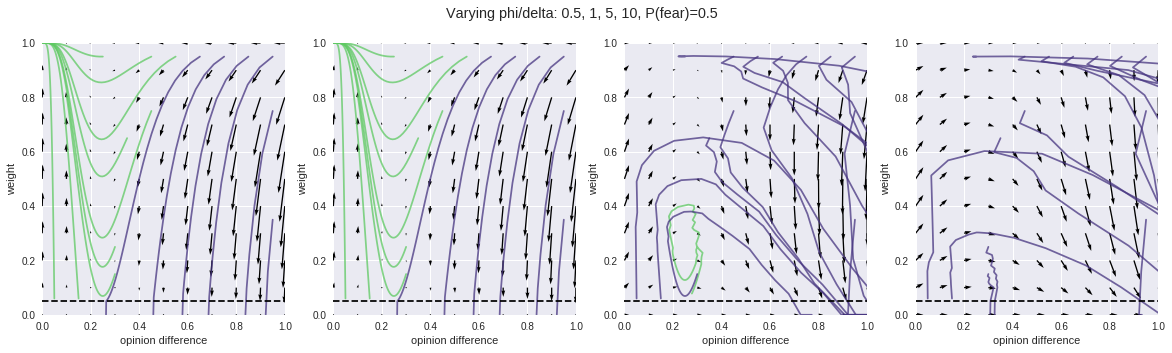

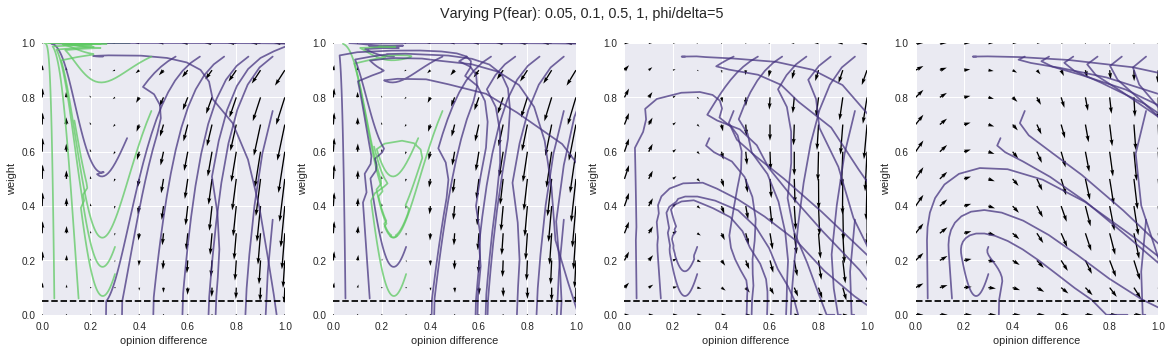

In [369]:
import itertools
import scipy

alpha = 0.03
beta = 0.3
gamma = 4
delta = 0.01
phi_over_delta = [0.5,1,5,10]
P_fear = [0.05,0.1,0.5,1]

cmap = plt.cm.viridis  # good for color blindness

plt.figure(figsize=(20,5))
plt.suptitle("Varying phi/delta: 0.5, 1, 5, 10, P(fear)=0.5")
for p in range(len(phi_over_delta)):
    plt.subplot(1,4,p+1)
    # Plot traces of how opinion and weight change over time
    for opinion, weight in [
        [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
        [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
        [0.95, 0.35], [0.3, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
    ]:
        ow = [[opinion, 0.0, weight, 0.0]]
        for i in range(100):
            if ow[-1][3] < delta:
                ow[-1][3] = 0
            else:
                ow[-1][3] -= delta
            delta_o = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0]) \
            + ow[-1][3] * np.sign(ow[-1][0]) 
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            new_fear = ow[-1][3]
            if random.uniform(0,1)<P_fear[2]:
                new_fear += delta * phi_over_delta[p] * ow[-1][2]
            ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight, new_fear])
        plt.plot(
            [row[0] - row[1] for row in ow],
            [row[2] for row in ow],
            color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
            alpha=0.75)

    # Plot vector field
    opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
    weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
    ow_grid = scipy.meshgrid(opinion, weight)
    delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0] + P_fear[2]*delta*phi_over_delta[p]
    delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
    plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

    # Annotate plot
    plt.xlabel('opinion difference')
    plt.ylabel('weight')
    plt.plot([0, 1], [0.05, 0.05], 'k--')
    plt.xlim(0,1)
    plt.ylim(0,1)

plt.figure(figsize=(20,5))
plt.suptitle("Varying P(fear): 0.05, 0.1, 0.5, 1, phi/delta=5")
for p in range(len(P_fear)):
    plt.subplot(1,4,p+1)
    # Plot traces of how opinion and weight change over time
    for opinion, weight in [
        [0.25, 0.95], [0.45, 0.95], [0.55, 0.95], [0.65, 0.95], [0.75, 0.95],
        [0.85, 0.95], [0.95, 0.95], [0.35, 0.65], [0.45, 0.75], [0.95, 0.75],
        [0.95, 0.35], [0.3, 0.25], [0.3, 0.15], [0.15, 0.06], [0.05, 0.06]
    ]:
        ow = [[opinion, 0.0, weight, 0.0]]
        for i in range(100):
            if ow[-1][3] < delta:
                ow[-1][3] = 0
            else:
                ow[-1][3] -= delta
            delta_o = alpha * ow[-1][2] * (ow[-1][1] - ow[-1][0]) \
            + ow[-1][3] * np.sign(ow[-1][0]) 
            delta_w = (
                beta * ow[-1][2] * (1-ow[-1][2]) *
                (1-gamma*abs(ow[-1][1] - ow[-1][0])))
            new_weight = ow[-1][2] + delta_w
            if new_weight < 0.05:
                new_weight = 0
            new_fear = ow[-1][3]
            if random.uniform(0,1)<P_fear[p]:
                new_fear += delta * phi_over_delta[2] * ow[-1][2]
            ow.append([ow[-1][0] + delta_o, ow[-1][1] - delta_o, new_weight, new_fear])
        plt.plot(
            [row[0] - row[1] for row in ow],
            [row[2] for row in ow],
            color=(cmap(0.15) if ow[-1][2] == 0 else cmap(0.75)),
            alpha=0.75)

    # Plot vector field
    opinion = scipy.linspace(0, 1, 11)  # the difference in opinion, |o_i - o_j|
    weight = scipy.linspace(0, 1, 11)   # the edge weight, w_ij
    ow_grid = scipy.meshgrid(opinion, weight)
    delta_o_grid = -2*alpha * ow_grid[1] * ow_grid[0] + P_fear[p]*delta*phi_over_delta[2]
    delta_w_grid = beta * ow_grid[1] * (1-ow_grid[1]) * (1 - gamma * ow_grid[0])
    plt.quiver(ow_grid[0], ow_grid[1], delta_o_grid, delta_w_grid)

    # Annotate plot
    plt.xlabel('opinion difference')
    plt.ylabel('weight')
    plt.plot([0, 1], [0.05, 0.05], 'k--')
    plt.xlim(0,1)
    plt.ylim(0,1)

plt.show()



### Implementation

Below is a modification of the original model to accomodate my changes in the update() function:

In [0]:
from matplotlib import pyplot as plt
import networkx as nx
import random
import numpy as np

In [0]:
class SocialDynamicsSimulation:
    '''
    Simulate social dynamics by strengthening opinions and connection weights
    based on random interactions between nodes.
    '''

    def __init__(self, network_size=50, alpha=0.03, beta=0.3, gamma=4,delta=0.1,epsilon=3,phi=0.05):
        '''
        Inputs:

            network_size (int) The number of nodes in the random Watts-Strogatz
              small-world network. Default: 50.

            alpha (float) The rate at which nodes adjust their opinions to
              match neighboring nodes' opinions during interactions.
              Default: 0.03.

            beta (float) The rate at which edge weights are changed in
              response to differing opinions. Default: 0.3.

            gamma (float) The pickiness of nodes. Nodes with opinions differing
              by more than 1/gamma will result in an edge weight decreasing.
              Default: 4.
        '''
        self.network_size = network_size
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.epsilon = epsilon
        self.phi = phi
        self.delta = delta

    def initialize(self):
        '''
        Initialize the simulation with a random graph, with random 0 or 1
        opinions assigned to all nodes and initial edge weights of 0.5.
        '''
        self.graph = nx.nx.barabasi_albert_graph_graph(50, 5, 0.5)
        for edge in self.graph.edges:
            self.graph.edges[edge]['weight'] = 0.5
        for node in self.graph.nodes:
            self.graph.nodes[node]['opinion'] = random.randint(0, 1)
            # initiate fear at 0
            self.graph.nodes[node]['fear'] = 0
        self.layout = nx.spring_layout(self.graph)  # Initial visual layout
        self.step = 0

    def observe(self):
        '''
        Draw the state of the network.
        '''
        self.layout = nx.spring_layout(self.graph, pos = self.layout, iterations=5)
        #plt.clf()
        nx.draw(
            self.graph, pos=self.layout, with_labels=True,
            node_color=[self.graph.nodes[i]['opinion'] for i in self.graph.nodes],
            edge_color=[self.graph.edges[i, j]['weight'] for i, j in self.graph.edges],
            edge_cmap=plt.cm.binary, edge_vmin=0, edge_vmax=1,
            alpha=0.7, vmin=0, vmax=1,cmap=plt.cm.autumn)
        #plt.title('Step: ' + str(self.step))

    def update(self):
        nodes = list(self.graph.nodes)
        # Decay fear linerly by delta, cap at 0.
        for n in nodes:
            if self.graph.nodes[n]['fear']>=self.delta:
                self.graph.nodes[n]['fear']-=self.delta
        # Eliminate the most influential dissenters if they pass threshold epsilon
        # Based on the danger metric
        weights = [sum(self.graph.edges[e]['weight'] \
                       for e in list(self.graph.edges(n))\
                       if (self.graph.nodes[e[1]]['opinion']<0.5)) \
                   for n in nodes]
        opinions_compliment = [1-self.graph.nodes[n]['opinion'] for n in nodes]
        rank = np.multiply(weights,opinions_compliment)
        targets = np.argwhere(rank>=self.epsilon)
        for t in np.sort(targets)[::-1]:
            # print("eliminating node: " +str(t[0]))
            # Spread fear/dissent
            for neighbor in self.graph.neighbors(t[0]):
                self.graph.nodes[neighbor]['fear']+= \
                self.phi*self.graph.edges[(t[0],neighbor)]['weight']
            # Eliminate
            self.graph.remove_node(t[0])
            # Relabel nodes nicely
            relabels = {i:(i-1) for i in range(t[0]+1,len(self.graph.nodes)+1)}
            nx.relabel_nodes(self.graph,relabels,False)
        if random.uniform(0, 1) < 0.01:
            # Create a new edge with weight 0.5 between two unconnected nodes
            while True:
                new_edge = random.sample(nodes, 2)
                if new_edge not in self.graph.edges:
                    break
            self.graph.add_edge(new_edge[0], new_edge[1], weight=0.5)
        else:
            # Select a random edge and update node opinions and edge weight
            edge = random.choice(list(self.graph.edges))
            weight = self.graph.edges[edge]['weight']
            opinions = [self.graph.nodes[n]['opinion'] for n in edge]
            # include fear in new equation for opinion change
            fears = [self.graph.nodes[n]['fear'] for n in edge]
            for i in [0, 1]:
                self.graph.nodes[edge[i]]['opinion'] = (
                    opinions[i] + self.alpha * weight * (opinions[1-i] - opinions[i]))+fears[i]*np.sign(0.5-opinions[1])
            self.graph.edges[edge]['weight'] = (
                weight +
                self.beta * weight * (1-weight) *
                (1 - self.gamma * abs(opinions[0] - opinions[1])))
            # Remove very weak connections
            if self.graph.edges[edge]['weight'] < 0.05:
                self.graph.remove_edge(*edge)
        self.step += 1

### Simulation Analysis

We run our simulation with different initial parameter values for the three new parameters:

#### Simulation Method

In [0]:
def run_example(delta,epsilon,phi):
    sim = SocialDynamicsSimulation(delta=delta,epsilon=epsilon,phi=phi)
    sim.initialize()
    plt.figure(figsize=(20,4))
    plt.suptitle("10,000 steps under parameters: delta="+str(delta) \
                 +", epsilon="+str(epsilon)+", phi="+str(phi))
    plt.subplot(1,5,1)
    sim.observe()
    for i in range(4):
        for j in range(2500):
            sim.update()
        plt.subplot(1,5,i+2) 
        sim.observe()

#### Varying Phi/Delta

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


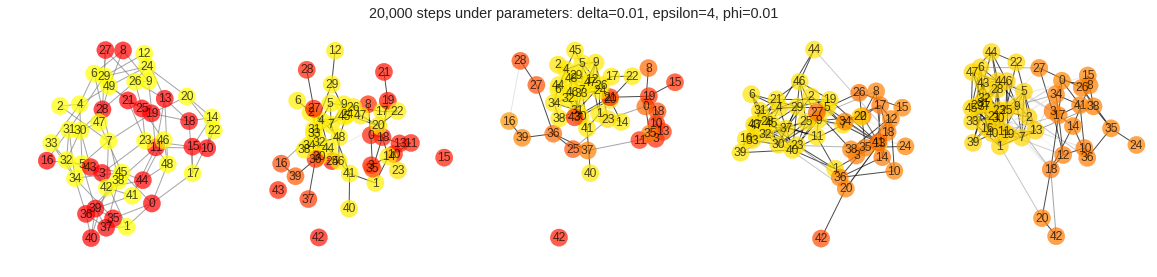

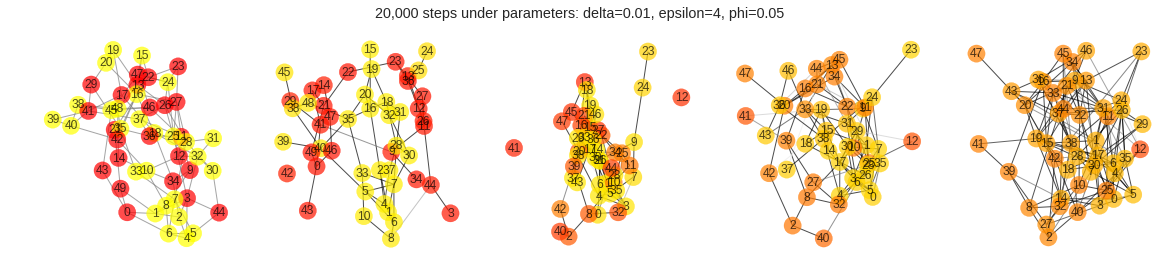

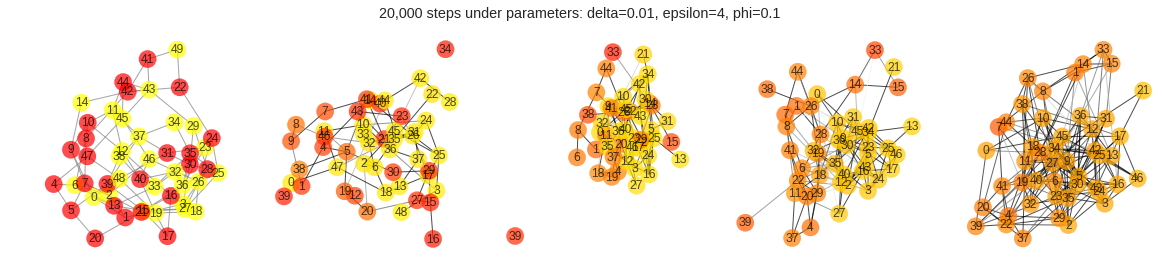

In [374]:
run_example(0.01,4,0.01)
run_example(0.01,4,0.05)
run_example(0.01,4,0.1)

plt.show()

#### Varying Epsilon

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


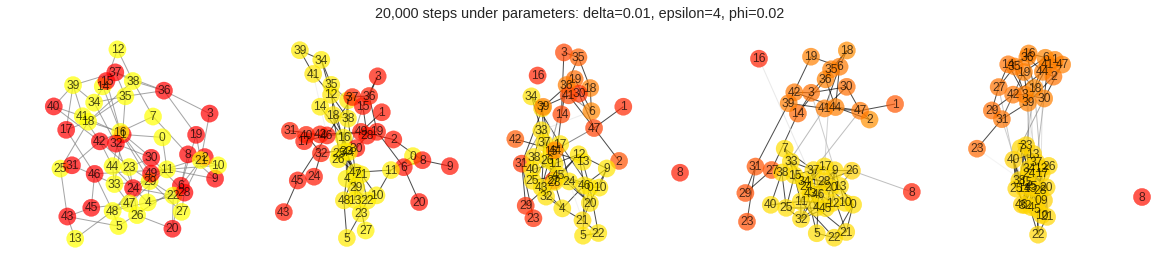

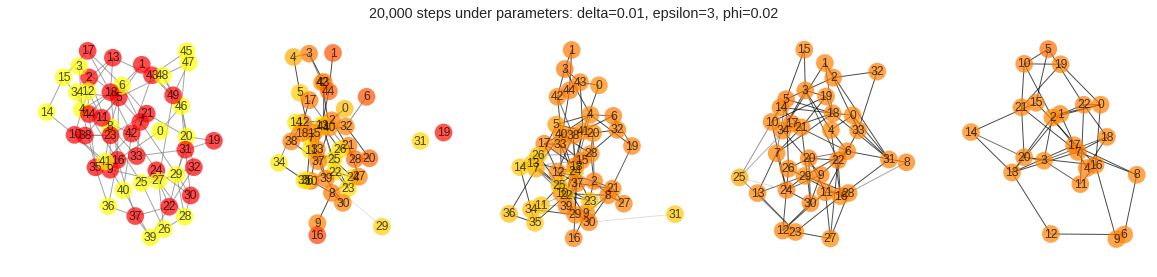

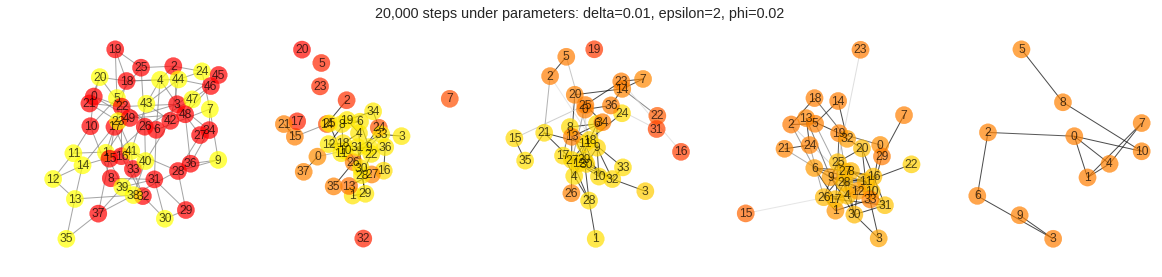

In [373]:
run_example(0.01,4,0.02)
run_example(0.01,3,0.02)
run_example(0.01,2,0.02)

plt.show()

Since I try to model my lawn-mower strategy with high accuracy, I needed to use a network graph that exhibited scale-free behavior for node degree, as I am bound to see in real life. I chose the Barabasi-Albert graph upon which to run my simulations. 

It seems that I will have to be careful if I ever decide to employ my lawn-mower strategy.

Varying the ratio of phi and delta, I see that fear is a strong unifying tool. However, as my citizens unite, they also lose average loyalty, putting me in a dangerous position.

Varying the elimination threshold epsilon, I see that I must be careful not to wipe out most of my population. Under high effect of fear (phi/delta ration,) I might easily have to resort to genocide to prevent revolt, and lose my country regardless.

It seems that for effective control I must attempt to lower the impact of fear. Even then, I will inevitable divide the people rather than bring them all under my wing. A better model might include a parameter to simulate the strength of my intelligence corps: the more I know about resistance leaders that aren't connected to my loyal populace, the better I can incite fear in my enemies without arouding discontent among my people. 